In [1]:
from os import remove
import random
from pathlib import Path
from PIL import Image
import pickle
import augly.image as imaugs
import numpy as np
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from oemer.bbox import get_bbox, merge_nearby_bbox, draw_bounding_boxes, rm_merge_overlap_bbox
from oemer.build_label import find_example

In [2]:
TARGET_WIDTH = 40
TARGET_HEIGHT = 70
DISTANCE = 10

DATASET_PATH = "./ds2_dense/segmentation"

In [3]:
def _collect(color, out_path, samples=1000):
    out_path = Path(out_path)
    if not out_path.exists():
        out_path.mkdir()

    cur_samples = 0
    add_space = 10
    idx = 0
    while cur_samples < samples:
        arr = find_example(DATASET_PATH, color)
        if arr is None:
            continue
        arr[arr!=200] = 0
        boxes = get_bbox(arr)
        if len(boxes) > 1:
            boxes = merge_nearby_bbox(boxes, DISTANCE)
        boxes = rm_merge_overlap_bbox(boxes)
        for box in boxes:
            if idx >= samples:
                break
            print(f"{idx+1}/{samples}", end='\r')
            patch = arr[box[1]-add_space:box[3]+add_space, box[0]-add_space:box[2]+add_space]
            ratio = random.choice(np.arange(0.6, 1.3, 0.1))
            tar_w = int(ratio * patch.shape[1])
            tar_h = int(ratio * patch.shape[0])
            img = imaugs.resize(Image.fromarray(patch.astype(np.uint8)), width=tar_w, height=tar_h)

            seed = random.randint(0, 1000)
            img = imaugs.perspective_transform(img, seed=seed, sigma=3)
            img = np.where(np.array(img)>0, 255, 0)
            Image.fromarray(patch.astype(np.uint8)).save(out_path / f"{idx}.png")
            idx += 1

        cur_samples += len(boxes)
    print()

In [4]:
def collect_data(samples=1000):
    color_map = {
        74: "sharp",
        70: "flat",
        72: "natural",
#         97: 'rest_whole',
#         98: 'rest_half',
#         99: 'rest_quarter',
#         100: 'rest_8th',
#         101: 'rest_16th',
#         102: 'rest_32nd',
#         103: 'rest_64th',
#         104: 'rest_128th'
        # 10: 'gclef',
        # 13: 'fclef',
        # 추가: time signature에 해당하는 데이터
#         21: 'timesig_0',
#         22: 'timesig_1',
#         23: 'timesig_2',
#         24: 'timesig_3',
#         25: 'timesig_4',
#         26: 'timesig_5',
#         27: 'timesig_6',
#         28: 'timesig_7',
#         29: 'timesig_8',
#         30: 'timesig_9',
#         33: 'timesig_4_4',
#         34: 'timesig_2_2',
    }
    
    for color, name in color_map.items():
        print('Current', name)
        _collect(color, f"./ds2_dense/train_data/{name}", samples=samples)
        _collect(color, f"./ds2_dense/val_data/{name}", samples=samples)  # 검증 데이터 생성 및 저장
        _collect(color, f"./ds2_dense/test_data/{name}", samples=samples)

In [5]:
def train(folders):
    class_map = {idx: Path(ff).name for idx, ff in enumerate(folders)}
    train_data = []
    train_labels = []
    val_data = []  # 추가: 검증 데이터
    val_labels = []  # 추가: 검증 데이터
    samples = None
    print("Loading data")
    for cidx, folder in enumerate(folders):
        folder = Path(folder)
        idx = 0
        for ff in folder.glob('*.png'):
            if samples is not None and idx >= samples:
                break
            img = Image.open(ff).resize((TARGET_WIDTH, TARGET_HEIGHT))
            arr = np.array(img)
            if idx % 5 == 0:  # 추가: 검증 데이터를 위해 1/5 비율로 분할
                val_data.append(arr)
                val_labels.append(cidx)
            else:
                train_data.append(arr)
                train_labels.append(cidx)
            idx += 1

    train_data = np.array(train_data)
    train_labels = np.array(train_labels)
    val_data = np.array(val_data)  # 추가: 검증 데이터
    val_labels = np.array(val_labels)  # 추가: 검증 데이터

    model = models.Sequential([
    layers.Input(shape=(TARGET_HEIGHT, TARGET_WIDTH, 1)),
    
    # 첫 번째 Convolutional Layer
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    # 두 번째 Convolutional Layer
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    # 세 번째 Convolutional Layer
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    # 네 번째 Convolutional Layer
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    # Fully Connected Layer
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(folders), activation='softmax')
])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=20, batch_size=32)  # 수정: 검증 데이터 사용
    return model, class_map, history

In [6]:
def test_tf(model, folders):
    test_x = []
    test_y = []
    print("Loading data")
    for cidx, folder in enumerate(folders):
        folder = Path(folder)
        files = list(folder.iterdir())
        random.shuffle(files)
        for ff in files:
            img = Image.open(ff).resize((TARGET_WIDTH, TARGET_HEIGHT))
            arr = np.array(img)
            test_x.append(arr)
            test_y.append(cidx)

    test_x = np.array(test_x)[..., np.newaxis]
    test_y = np.array(test_y)
    test_result = []
    batch_size = 32
    for idx in range(0, len(test_x), batch_size):
        data = test_x[idx:idx+batch_size]
        pred = model.predict(data)
        pidx = np.argmax(pred, axis=-1)
        test_result.extend(list(pidx))

    test_result = np.array(test_result)
    tp = test_result[test_result==test_y].size
    acc = tp / len(test_y)
    print("Accuracy: ", acc)

In [7]:
def predict(region, model_name):
    if np.max(region) == 1:
        region *= 255
    m_info = pickle.load(open(f"sklearn_models/{model_name}.model", "rb"))
    model = m_info['model']
    w = m_info['w']
    h = m_info['h']
    region = Image.fromarray(region.astype(np.uint8)).resize((w, h))
    pred = model.predict(np.array(region).reshape(1, -1))
    return m_info['class_map'][pred[0]]

In [8]:
samples = 1000

collect_data(samples=samples)

folders = ["sharp", "flat", "natural",]
model_name = "sfn"

Current sharp
1000/1000
1000/1000
1000/1000
Current flat
1000/1000
1000/1000
1000/1000
Current natural
1000/1000
1000/1000
1000/1000


In [9]:
from tensorflow.keras import models, layers
model, class_map, history = train([f"ds2_dense/train_data/{folder}" for folder in folders])

Loading data
Epoch 1/20
75/75 [==============================] - 16s 197ms/step - loss: 0.2575 - accuracy: 0.9621 - val_loss: 0.0265 - val_accuracy: 0.9933
Epoch 2/20
75/75 [==============================] - 15s 201ms/step - loss: 0.0256 - accuracy: 0.9933 - val_loss: 0.0158 - val_accuracy: 0.9967
Epoch 3/20
75/75 [==============================] - 14s 191ms/step - loss: 0.0369 - accuracy: 0.9937 - val_loss: 0.0036 - val_accuracy: 0.9983
Epoch 4/20
75/75 [==============================] - 14s 188ms/step - loss: 0.0156 - accuracy: 0.9967 - val_loss: 0.0103 - val_accuracy: 0.9967
Epoch 5/20
75/75 [==============================] - 14s 187ms/step - loss: 0.0014 - accuracy: 0.9992 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 6/20
75/75 [==============================] - 15s 201ms/step - loss: 0.0026 - accuracy: 0.9987 - val_loss: 0.0246 - val_accuracy: 0.9983
Epoch 7/20
75/75 [==============================] - 15s 202ms/step - loss: 0.0148 - accuracy: 0.9971 - val_loss: 0.0267 - val_acc

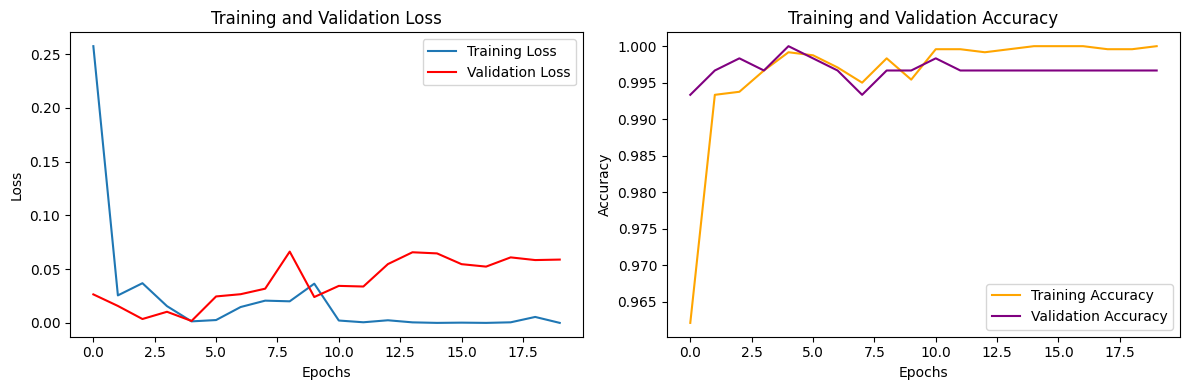

In [10]:
import matplotlib.pyplot as plt

# 훈련 과정에서의 손실, 정확도, 검증 손실, 검증 정확도 값을 가져옴
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# 그래프 생성 및 표시
plt.figure(figsize=(12, 4))

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Training Accuracy', color='orange')
plt.plot(val_accuracy, label='Validation Accuracy', color='purple')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
test_tf(model, [f"ds2_dense/test_data/{folder}" for folder in folders])

Loading data
1/1 [==============================] - 0s 97ms/step
Accuracy:  0.999


In [12]:
output = {'model': model, 'w': TARGET_WIDTH, 'h': TARGET_HEIGHT, 'class_map': class_map}
pickle.dump(output, open(f"sklearn_models/{model_name}.model", "wb"))